### Dataset after augmentation

In [1]:
import os

root_folder= 'D:/yogi/shoppin/ImageNet-Mini/augmented_images_200'
img_paths= []
labels= []

for dir, folder, files in os.walk(root_folder):

  for file in files:
    img_path= os.path.join(dir, file)
    img_paths.append(img_path)
    labels.append(os.path.basename(dir))

In [2]:
from sklearn import preprocessing

label_encoder= preprocessing.LabelEncoder()
img_ids= label_encoder.fit_transform(labels)

In [3]:
from math import floor
import random

def split_data(img_paths, img_ids):

    # Combine data and labels into a list of tuples
    combined = list(zip(img_paths, img_ids))

    random.seed(42)

    # Shuffle the combined list
    random.shuffle(combined)

    # Split the shuffled combined list into two lists
    split_index1 = floor(len(combined) * 0.8)
    split_index2 = floor(len(combined) * 0.9)

    train_combined  = combined[:split_index1]
    test_combined   = combined[split_index1:split_index2]
    enroll_combined = combined[split_index2:]

    # Unpack the combined tuples into separate paths and labels
    train_img_paths, train_img_ids   = zip(*train_combined)
    test_img_paths, test_img_ids     = zip(*test_combined)
    enroll_img_paths, enroll_img_ids = zip(*enroll_combined)

    return train_img_paths, train_img_ids, test_img_paths, test_img_ids, enroll_img_paths, enroll_img_ids

In [4]:
train_img_paths, train_img_ids, test_img_paths, test_img_ids, enroll_img_paths, enroll_img_ids= split_data(img_paths, img_ids)

### Dataloader

In [5]:
import os
import pandas as pd
from PIL import Image
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels= labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
def transform_image():
  
  transform= transforms.Compose([
      transforms.RandomHorizontalFlip(),
      transforms.RandomResizedCrop(224),
      transforms.ToTensor(),
      transforms.Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
      transforms.Normalize(mean=0.5,  # Standard ImageNet normalization
      std=0.5)
  ])

  return transform

In [8]:
training_data   = CustomImageDataset(train_img_paths, train_img_ids, transform_image())
val_data        = CustomImageDataset(test_img_paths, test_img_ids, transform_image())

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

### Build Autoencoder

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.models import vgg16, resnet50

In [10]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256, num_classes= 200):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # -> [64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # -> [128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # -> [256, 28, 28]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # -> [512, 14, 14]
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Flatten(),  # Flatten to [512 * 14 * 14]
            nn.Linear(512 * 14 * 14, latent_dim)  # Latent space
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512 * 14 * 14),
            nn.Unflatten(1, (512, 14, 14)),  # Reshape to [512, 14, 14]
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [256, 28, 28]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [128, 56, 56]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [64, 112, 112]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> [3, 224, 224]
            nn.Sigmoid()  # Output pixel values in [0, 1]
        )

        # Classification Head
        self.classifier = nn.Linear(latent_dim, num_classes)
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        # Classify using the latent space
        classification = self.classifier(latent)
        return latent, reconstruction, classification

In [55]:
# Pre-trained VGG16 for Perceptual Loss
class PerceptualLoss(nn.Module):
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        resnet = resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:8]).to(device)
        # vgg = vgg16(pretrained=True).features  # Load only the feature extractor part
        # self.vgg = nn.Sequential(*list(vgg.children())[:16])  # Up to block3_conv3
        for param in self.features.parameters():
            param.requires_grad = False  # Freeze VGG16 weights
    
    def forward(self, x, y):
        # Extract features from VGG16
        x_features = self.features(x)
        y_features = self.features(y)
        # Compute MSE between feature maps
        loss = nn.functional.mse_loss(x_features, y_features)
        return loss

# Combined Loss Function
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.perceptual_loss = PerceptualLoss()
        self.reconstruction_loss = nn.MSELoss()

    def forward(self, output, target):
        # Reconstruction loss
        reconstruction = self.reconstruction_loss(output, target)
        # Perceptual loss
        perceptual = self.perceptual_loss(output, target)
        # Combine losses with a weight (e.g., 0.1 for perceptual loss)
        return reconstruction + 0.1 * perceptual

In [12]:
model = Autoencoder(latent_dim=256).to(device)

In [64]:
# model.load_state_dict(torch.load('./checkpoints/autoencoder.pth'))

In [58]:
# # Example Training Loop
# criterion = CombinedLoss().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

c:\Users\ShivajiWankhede\anaconda3\envs\llm\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ShivajiWankhede\anaconda3\envs\llm\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# criterion = nn.MSELoss()
criterion_reconstruction = nn.MSELoss()
criterion_classification = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [15]:
def validate(model, val_loader, criterion_reconstruction, criterion_classification):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            latent, outputs, classification = model(inputs)
            
            # Loss computation
            # loss = criterion_reconstruction(outputs, images)
            reconstruction_loss = criterion_reconstruction(outputs, inputs)
            classification_loss = criterion_classification(classification, labels)
            loss = reconstruction_loss + classification_loss

            val_loss += loss.item()

            _, predicted = classification.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Validation - Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%")

In [30]:
epochs = 10

for epoch in range(epochs):
    correct= 0
    total= 0
    for images , labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        latent, outputs, classification = model(images)
        
        # Loss computation
        # loss = criterion_reconstruction(outputs, images)
        reconstruction_loss = criterion_reconstruction(outputs, images)
        classification_loss = criterion_classification(classification, labels)
        loss = reconstruction_loss + classification_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predictions = classification.max(1)

        correct += predictions.eq(labels).sum().item()
        total += labels.size(0)
        
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f} | Accuracy: {correct/total}")
    # Validation
    validate(model, val_dataloader, criterion_reconstruction, criterion_classification)

Epoch [1/10], Loss: 1.2304 | Accuracy: 0.8221709838959542
Validation - Loss: 1.4272, Accuracy: 72.48%
Epoch [2/10], Loss: 0.9037 | Accuracy: 0.8230716575998848
Validation - Loss: 1.4398, Accuracy: 73.80%
Epoch [3/10], Loss: 0.8874 | Accuracy: 0.8300248585942285
Validation - Loss: 1.4541, Accuracy: 72.62%
Epoch [4/10], Loss: 0.9204 | Accuracy: 0.8349245235436106
Validation - Loss: 1.4647, Accuracy: 73.75%
Epoch [5/10], Loss: 0.9200 | Accuracy: 0.8334113917210073
Validation - Loss: 1.3542, Accuracy: 75.16%
Epoch [6/10], Loss: 1.0876 | Accuracy: 0.8402204849227222
Validation - Loss: 1.4052, Accuracy: 74.09%
Epoch [7/10], Loss: 1.2391 | Accuracy: 0.8479662787765249
Validation - Loss: 1.3863, Accuracy: 74.64%
Epoch [8/10], Loss: 0.8300 | Accuracy: 0.8503080304067443
Validation - Loss: 1.3549, Accuracy: 75.16%
Epoch [9/10], Loss: 0.9246 | Accuracy: 0.8534423748964225
Validation - Loss: 1.3184, Accuracy: 75.97%
Epoch [10/10], Loss: 0.6033 | Accuracy: 0.8529019706740641
Validation - Loss: 1.34

In [31]:
torch.save(model.state_dict(), './checkpoints/autoencoder3.pth')

### Enrollment

In [23]:
import json

# Convert tensors to lists for serialization
def tensor_to_list(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()  # Convert tensor to list
    raise TypeError(f"Object of type {obj.__class__.__name__} is not serializable")

def enroll_image(image_path, directory= './database_autoencoder', model=None, weights= True, transformation= transform_image()):

  image= Image.open(image_path).convert('RGB')
  transformed_image= transformation(image).unsqueeze(0).to(device)


  model.eval()  
  embeddings= model(transformed_image).reshape(1,-1)
  
  # name= image_path.split('.JPEG')[0] + '.json'
  name= os.path.basename(image_path).split('.JPEG')[0] + '.json'
  # print(name)

  output_path= os.path.join(directory, name)
  # print(output_path)
  value= {image_path: embeddings}
  # print(value)

  with open(output_path, 'w') as f:
      json.dump(value, f, default=tensor_to_list)

In [32]:
# Extract features
encoder = model.encoder

for i, path in enumerate(train_img_paths):
    print(i)
    enroll_image( path, model= encoder)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Evaluation

In [33]:
import requests
from PIL import Image
from io import BytesIO

def download_image(url):
    # try:
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    
    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    return img

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import json

def precision_at_k(image_path=None, url= None, model= None, database_folder='./database_autoencoder', k=1, transformation= transform_image()):
    
    probe_label= os.path.basename(os.path.dirname(image_path))

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)

    # if model== None:
    #     model= resnet34(weights=True)
    #     model.load_state_dict(torch.load('checkpoints/model_200.pth'))
    #     model = nn.Sequential(*list(model.children())[:-1])

    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()

    scores= []

    # Iterate over all JSON files in the database folder
    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            # Load embeddings from the current JSON file
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            # Calculate cosine similarity for each embedding in the JSON file
            for path, emb in database.items():
                folder= os.path.basename(os.path.dirname(path))
                # labels.append(folder)
                emb_tensor = torch.tensor(emb).cpu().detach().numpy()
                score = cosine_similarity(emb_tensor.reshape(1, -1), query_embedding.numpy())
                scores.append((folder, score))


    sorted_scores = sorted(scores, key=lambda x: x[1][0][0], reverse=True)

    True_positive= 0


    for i in range(k):
        if sorted_scores[i][0] == probe_label:
            True_positive += 1

    precision= True_positive/k

    print(f'Precision@k={k}: {precision}')

    return precision

In [35]:
def recall_at_k(image_path=None, url= None, model= None, database_folder='./database_autoencoder', k=1, transformation= transform_image()):
    
    probe_label= os.path.basename(os.path.dirname(image_path))

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)

    # if model== None:
    #     model= resnet34(weights=True)
    #     model.load_state_dict(torch.load('checkpoints/model_200.pth'))
    #     model = nn.Sequential(*list(model.children())[:-1])

    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()

    scores= []
    True_positive= 0
    Total_relevant_items= 0

    # Iterate over all JSON files in the database folder
    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            # Load embeddings from the current JSON file
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            # Calculate cosine similarity for each embedding in the JSON file
            for path, emb in database.items():
                folder= os.path.basename(os.path.dirname(path))

                if folder == probe_label:
                    Total_relevant_items += 1
                
                emb_tensor = torch.tensor(emb).cpu().detach().numpy()
                score = cosine_similarity(emb_tensor.reshape(1, -1), query_embedding.numpy())
                scores.append((folder, score))


    sorted_scores = sorted(scores, key=lambda x: x[1][0][0], reverse=True)



    for i in range(k):
        if sorted_scores[i][0] == probe_label:
            True_positive += 1

    

    recall= True_positive/Total_relevant_items

    print(f'recall@k={k}: {recall}')

    return recall    

In [36]:
sum= 0
for img_path in test_img_paths[100:110]:
    value= precision_at_k(img_path, model= encoder, k=10)
    sum += value

print(f'average precision @ k=10: {sum/10}')

Precision@k=10: 0.5
Precision@k=10: 0.3
Precision@k=10: 0.0
Precision@k=10: 0.9
Precision@k=10: 1.0
Precision@k=10: 0.9
Precision@k=10: 0.9
Precision@k=10: 1.0
Precision@k=10: 0.1
Precision@k=10: 0.4
average precision @ k=10: 0.6


In [37]:
sum= 0
for img_path in test_img_paths[100:110]:
    value= recall_at_k(img_path, model= encoder, k=50)
    sum += value

print(f'average recall @ k=50: {sum/10}')

recall@k=50: 0.20512820512820512
recall@k=50: 0.11764705882352941
recall@k=50: 0.05042016806722689
recall@k=50: 0.06832298136645963
recall@k=50: 0.11728395061728394
recall@k=50: 0.09821428571428571
recall@k=50: 0.16363636363636364
recall@k=50: 0.20168067226890757
recall@k=50: 0.01680672268907563
recall@k=50: 0.09166666666666666
average recall @ k=50: 0.11308070749780039


### Probe

In [35]:
import requests
from PIL import Image
from io import BytesIO

def download_image(url):
    # try:
    # Send an HTTP GET request to the URL
    response = requests.get(url)
    response.raise_for_status()  # Raise an exception for HTTP errors
    
    # Open the image from the response content
    img = Image.open(BytesIO(response.content))

    return img

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

def top_k_matches(image_path=None, url= None, model= None, database_folder='./database_autoencoder', k=1, transformation= transform_image()):

    if url== None:
        image= Image.open(image_path)
        transformed_image= transformation(image).unsqueeze(0).to(device)
    else:
        image= download_image(url)
        transformed_image= transformation(image).unsqueeze(0).to(device)


    model.eval()

    with torch.no_grad():
        query_embedding= model(transformed_image).reshape(1,-1).cpu()

    scores= []

        # Iterate over all JSON files in the database folder
    for json_file in os.listdir(database_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(database_folder, json_file)
            
            # Load embeddings from the current JSON file
            with open(json_path, 'r') as file:
                database = json.load(file)
            
            # Calculate cosine similarity for each embedding in the JSON file
            for path, emb in database.items():
                emb_tensor = torch.tensor(emb).cpu().detach().numpy()
                score = cosine_similarity(emb_tensor.reshape(1, -1), query_embedding.numpy())
                scores.append((path, score))


    
    print(f'pehle scores: {scores}')

    # Sort the score list by the second value in reverse order
    sorted_scores = sorted(scores, key=lambda x: x[1][0][0], reverse=True)

    print(f'scores: {sorted_scores}')

    # Define the grid size (rows and columns)
    rows = k
    cols = 2  # Adjust rows and cols based on `k`


    # Plot the images
    fig, axes = plt.subplots(rows, cols, figsize=(10, 6))


    if rows == 1:
        axes = np.array([axes])  # Convert to 2D array with one row

    # Loop through each row to plot input image and the corresponding match
    for i in range(rows):
        # Plot the input image in the first column
        axes[i, 0].imshow(image)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Input Image')

        # Plot the corresponding top match in the second column
        if i < k:
            retrieved_image = Image.open(sorted_scores[i][0])
            axes[i, 1].imshow(retrieved_image)
            axes[i, 1].axis("off")
            axes[i, 1].set_title(f"Match {i + 1}")
        else:
            axes[i, 1].axis("off")  # Turn off any extra axes

    plt.tight_layout()
    plt.show()
    

    return sorted_scores

pehle scores: [('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_2.JPEG', array([[0.08276647]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_3.JPEG', array([[0.20477146]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n02484975\\ILSVRC2012_val_00000013_aug_4.JPEG', array([[-0.00642867]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_1.JPEG', array([[0.35458136]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_2.JPEG', array([[0.32179034]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01729977\\ILSVRC2012_val_00000029_aug_4.JPEG', array([[0.30055305]], dtype=float32)), ('D:/yogi/shoppin/ImageNet-Mini/augmented_images\\n01910747\\ILSVRC2012_val_00000063_aug_1.JPEG', array([[0.3444729]], dtype=float32)), ('D:/yogi/shoppin/ImageNet

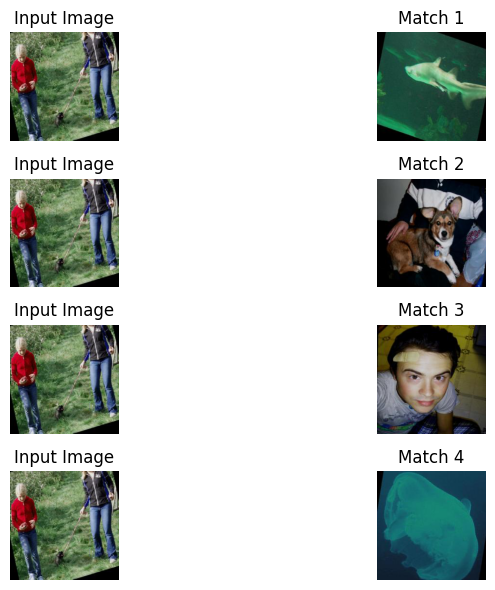

In [39]:
score= top_k_matches(image_path=enroll_img_paths[77], model= encoder, k=4)